In [1]:
import itertools
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

DEBUG = False
FALL_SIM_START = pd.Timestamp("2020-09-15")
FALL_SIM_END = pd.Timestamp("2021-06-05")
SPRING_SIM_START = pd.Timestamp("2021-01-16")
SPRING_SIM_END = pd.Timestamp("2021-05-21")
if DEBUG:
    FALL_SIM_END = FALL_SIM_START + pd.Timedelta(days=3)
    SPRING_SIM_END = SPRING_SIM_START + pd.Timedelta(days=3)

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")

pmsm = get_parallelizable_msm_criterion(
    prefix="gridsearch",
    fall_start_date=FALL_SIM_START,
    fall_end_date=FALL_SIM_END,
    spring_start_date=SPRING_SIM_START,
    spring_end_date=SPRING_SIM_END,
    mode="fall",
    debug=DEBUG,
)

# Modify Params

In [3]:
index_bundles = get_index_bundles(params)
hh_probs = index_bundles["hh"]
school_probs = index_bundles["school"]
young_educ_probs = index_bundles["young_educ"]
work_probs = index_bundles["work"]
other_probs = index_bundles["other"]

b117_rate = [("events", "b117_cases_per_100_000", "2021-01-31")]

vacation_probs = params.query("category == 'additional_other_vacation_contact'").index

rapid_test_level = [
    ("rapid_test_demand", "private_demand", "2021-03-31"),
    ("rapid_test_demand", "private_demand", "2021-04-06"),
]

free_probs = [
    bundle[0]
    for bundle in list(index_bundles.values())
    + [vacation_probs, b117_rate, rapid_test_level]
]

In [4]:
params.loc[other_probs, "value"] = 0.15875
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.012
params.loc[work_probs, "value"] = 0.1475
params.loc[hh_probs, "value"] = 0.1
params.loc[vacation_probs, "value"] = 0.5
params.loc[free_probs]

value
category                          subcategory            name                         
infection_prob                    educ_school_0          educ_school_0        0.012000
                                  educ_preschool_0       educ_preschool_0     0.005000
                                  households             households           0.100000
                                  work_non_recurrent     work_non_recurrent   0.147500
                                  other_non_recurrent    other_non_recurrent  0.158750
additional_other_vacation_contact probability            Winterferien         0.500000
events                            b117_cases_per_100_000 2021-01-31           0.756667
rapid_test_demand                 private_demand         2021-03-31           0.250000

In [5]:
params

value
category           subcategory            name                                
infection_prob     households             households                  0.100000
                   educ_school_0          educ_school_0               0.012000
                   educ_school_1          educ_school_1               0.012000
                   educ_school_2          educ_school_2               0.012000
                   educ_preschool_0       educ_preschool_0            0.005000
...                                                                        ...
rapid_test_demand  reaction               not_hh_contacts_multiplier  0.150000
events             b117_cases_per_100_000 2021-01-01                  0.000000
                                          2021-01-31                  0.756667
seasonality_effect seasonality_effect     weak                        0.200000
                                          strong                      0.300000

[810 rows x 1 columns]

# Run estimation

In [6]:
dimensions = "1d"

n_gridpoints = 3
loc1 = b117_rate
gridspec1 = (0.975, 1.0, n_gridpoints)
# only used if 2d
loc2 = work_probs
gridspec2 = (0.14, 0.16, n_gridpoints)

n_seeds = 16
n_cores = 48
mask = None

In [7]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

In [8]:
pd.to_pickle(results, "results.pkl")

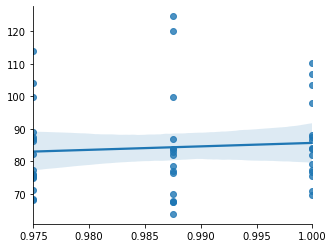

In [9]:
fig

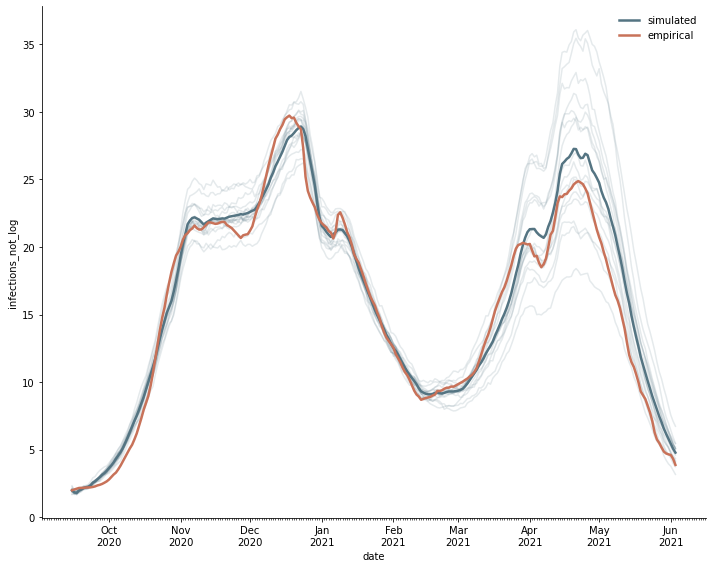

In [10]:
ix = best_index
plot_estimation_moment(results[ix], "aggregated_infections_not_log")

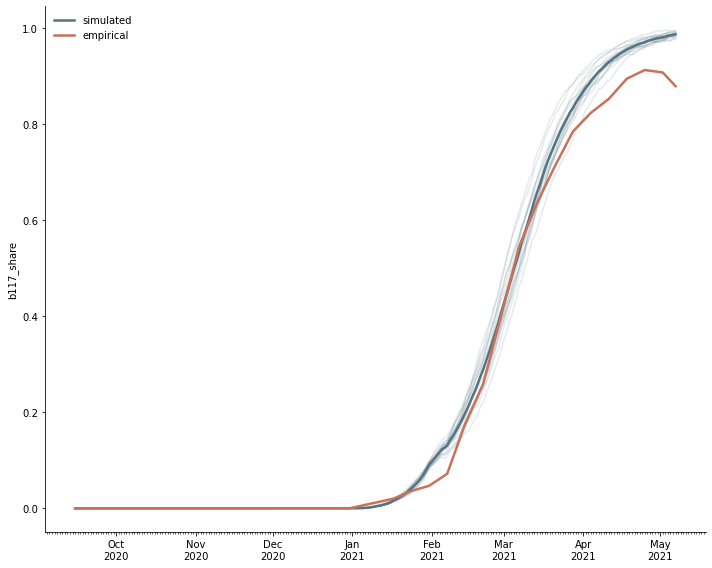

In [11]:
plot_estimation_moment(results[ix], "aggregated_b117_share")

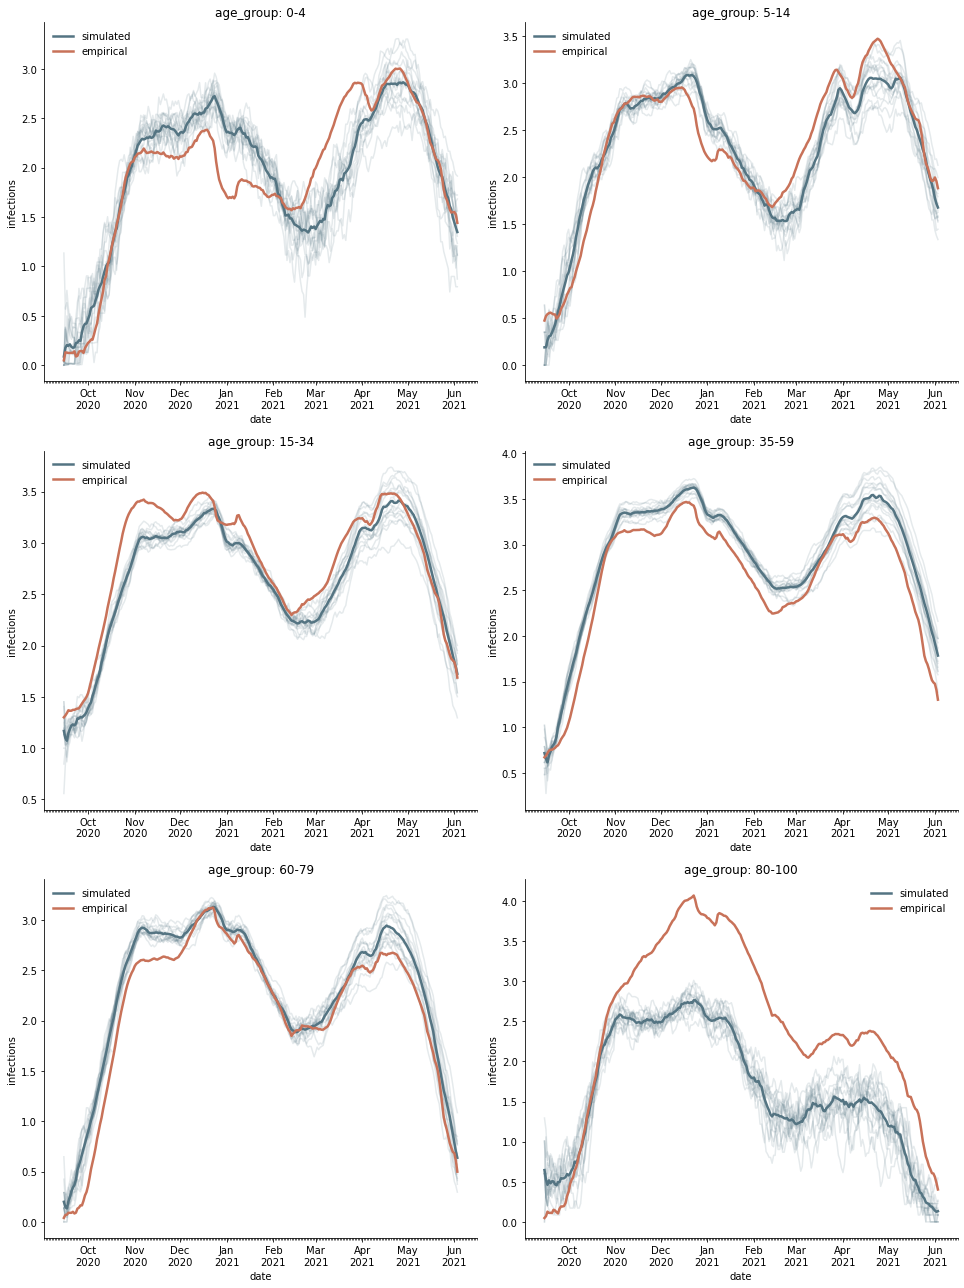

In [12]:
plot_estimation_moment(results[ix], "infections_by_age_group")

In [13]:
# plot_infection_channels(results[ix], aggregate=True)

In [14]:
grid[ix]

0.9875

In [15]:
best_index

1

In [16]:
np.mean([res["value"] for res in results[best_index]])

83.25402644691405